# Bank Customer Churn Prediciton using Clustering algorithm


![title](bank.jpeg)

In today's data-driven world, businesses are constantly looking for ways to leverage customer data to improve their services and increase profitability. One area where this is particularly important is in the banking industry, where customer churn can have a significant impact on revenue and profitability. Customer churn refers to the rate at which customers stop doing business with a bank or switch to a competitor. By analyzing customer data, banks can identify patterns and trends that may indicate a customer is likely to churn, allowing them to take proactive measures to retain the customer.

One approach to predicting customer churn is to use machine learning techniques, such as classification and clustering, to analyze customer data and identify patterns that may indicate a customer is at risk of churning. Classification models are used to predict whether a customer is likely to churn or not based on their demographic and transactional data. However, these models may not always be accurate, as they do not take into account the unique characteristics of each customer.

To improve the accuracy of churn prediction, clustering techniques can be used to group customers into similar segments based on their characteristics and behavior. By doing so, it is possible to identify more specific trends and patterns that may indicate a customer is at risk of churning. Once customers are clustered, separate classification models can be built for each cluster, allowing for more accurate predictions based on each customer's unique characteristics.

Comparing the accuracy of classification models built using the whole dataset versus models built for each cluster can help to determine which approach is more effective. If the cluster-specific models outperform the classification model on the whole dataset, this suggests that clustering is a useful technique for improving churn prediction accuracy. Additionally, this approach can help banks to identify specific factors that are driving customer churn in each cluster, allowing them to take more targeted and effective measures to retain customers.

In summary, using machine learning techniques such as classification and clustering can help banks to analyze customer data and predict churn more accurately. By building separate models for each cluster, banks can take a more targeted approach to customer retention, improving the effectiveness of their efforts to retain customers and increase profitability.

In [1]:
# here we will import the needed library in this project
# Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler


# Machine Leanring
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support # To evaluate models
from sklearn.model_selection import GridSearchCV



# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# here we will define some helper functions that we'ill use for this project 
# evaluation metrics stored in a dictionary
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    W_precision, W_recall, W_fbeta, _ = precision_recall_fscore_support(yt, yp, average = 'weighted')
    
    results_pos['precision'] = precision
    results_pos['Weighted precision'] = W_precision
    results_pos['recall'] = recall
    results_pos['Weighted recall'] = W_recall
    results_pos['f1score'] = f_beta
    results_pos['Weighted f1score'] = W_fbeta
    return results_pos

## 1- Importing the Data and Perform EDAs


In [3]:
df = pd.read_csv('Churn Modeling.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# removing "RowNumber", "Surname" and "CustomerId" becauuse they don't add any information
df_ready = df.drop(["RowNumber", "Surname", "CustomerId"], axis = 1)
df_ready.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [6]:
# checking if there is missing value in each column
df_ready.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
# checking each column type
df_ready.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [8]:
df_ready.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


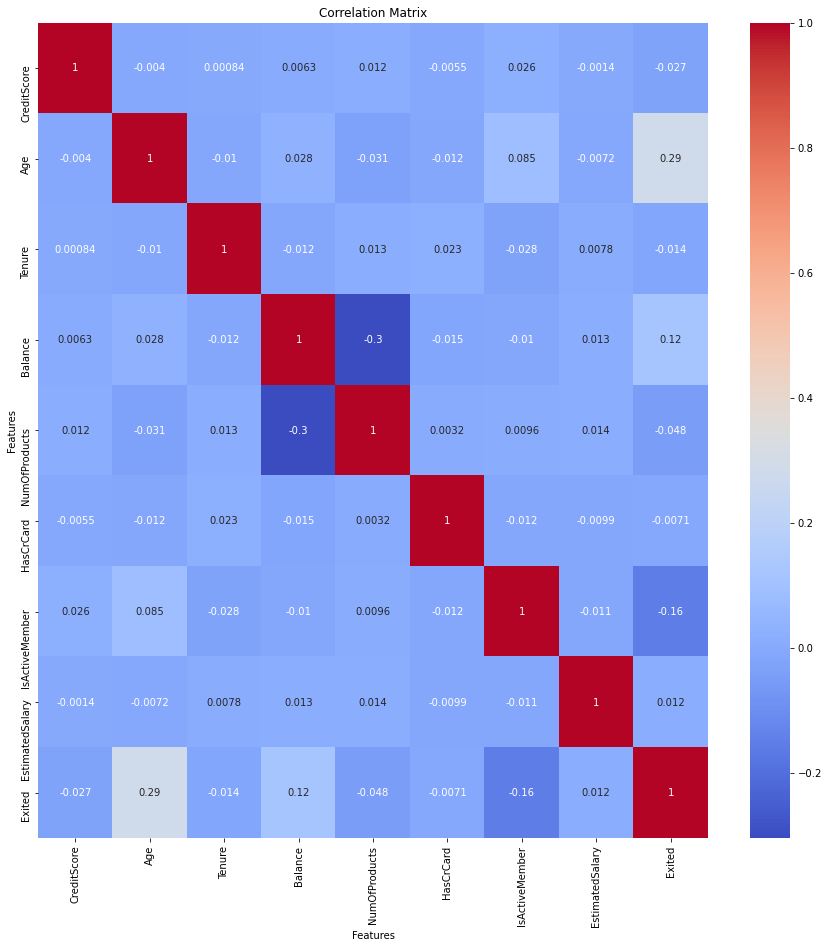

In [9]:
corr = df_ready.corr()
# Defining the size of the plot
plt.figure(figsize=(15,15)) # Set the size of the plot to 15x15 inches
# Create a heatmap using seaborn
sns.heatmap(corr, cmap='coolwarm', annot=True)

# Add title and axis labels
plt.title('Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')

# Show the plot
plt.show()

We can see from the correlation plot that "IsActiveMember" and "Exited" are the most correlated features, this is probabily because those who are active are less likely to exit the bank

## PreProcessing and Encoding

In [10]:
# Removing the categorical columns since we will be using the eucledian distance
df_ready = df_ready.drop('Geography', axis = 1)

# we will encode the gender column since it's a binary column
df_ready['Gender'] = label_binarize(df_ready.Gender, classes = ['Male', 'Female']).flatten()

## 3- Machine Learning

In [109]:
# splitting the data into test and training set
X = df_ready.drop('Exited', axis = 1)
y = df_ready.Exited.astype(int)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# check the shape of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (7500, 9) (7500,)
Testing set shape: (2500, 9) (2500,)


In [110]:
# scaling the training and the test sets
scale = MinMaxScaler()
X_train[X_train.columns] = scale.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scale.fit_transform(X_test[X_test.columns])
display(X_train.head())
display(X_test.head())

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
4901,0.646,0.0,0.554054,0.0,0.709683,0.333333,0.0,1.0,0.104931
4375,1.000,0.0,0.310811,0.8,0.242651,0.000000,1.0,0.0,0.158774
6698,0.750,1.0,0.175676,0.6,0.000000,0.000000,0.0,0.0,0.306365
9805,0.588,0.0,0.202703,0.7,0.695786,0.000000,0.0,1.0,0.219396
1101,0.706,0.0,0.148649,0.9,0.000000,0.333333,1.0,0.0,0.253098


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6252,0.492,0.0,0.189189,0.3,0.447500,0.333333,0.0,0.0,0.208904
4684,0.546,0.0,0.337838,0.1,0.000000,0.333333,1.0,1.0,0.731908
1731,0.502,1.0,0.351351,0.4,0.000000,0.333333,1.0,0.0,0.292777
4742,0.312,0.0,0.554054,0.8,0.551350,0.333333,1.0,1.0,0.853422
4521,0.420,1.0,0.121622,0.7,0.578391,0.000000,1.0,1.0,0.573346


In [111]:
# fitting the logistic regression model
lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

In [112]:
# printing a report for how well the model performed using different accuracy metrics
row= evaluate_metrics(y_test,y_pred)
row

{'accuracy': 0.8096,
 'precision': array([0.82642155, 0.56521739]),
 'Weighted precision': 0.7744941613844638,
 'recall': array([0.96505242, 0.18309859]),
 'Weighted recall': 0.8096,
 'f1score': array([0.8903731 , 0.27659574]),
 'Weighted f1score': 0.7683541617256486}

In [113]:
keys = ['accuracy','Weighted precision','Weighted recall','Weighted f1score']
row_results = list()
for key in keys:
       row_results.append(row.get(key))
row_results 

[0.8096, 0.7744941613844638, 0.8096, 0.7683541617256486]

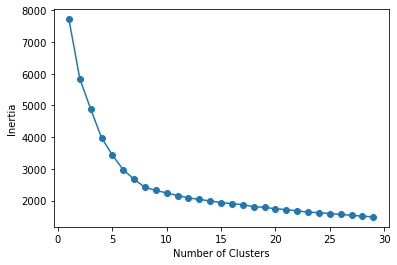

In [114]:
# trying Kmeans to find the best number of clusters that would reduce the inertia
inertia = []
list_num_clusters = list(range(1,30))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, random_state = 42)
    km.fit(X_train)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

the elbow method in kmeans shows that the optimal number of clusters is similar to DBSCAN, we will train a logistic regression model using each algorithm output and compare the results.


In [115]:
# We will choose 8 clusters for k means and then compare the results with DBSCAN
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(X_train)
labels_train_kmeans = kmeans.labels_
labels_test_kmeans = kmeans.predict(X_test)

X_train['kmeans'] = labels_train_kmeans
X_test['kmeans'] = labels_test_kmeans
display(X_train.head())
display(X_test.head())

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,kmeans
4901,0.646,0.0,0.554054,0.0,0.709683,0.333333,0.0,1.0,0.104931,2
4375,1.000,0.0,0.310811,0.8,0.242651,0.000000,1.0,0.0,0.158774,5
6698,0.750,1.0,0.175676,0.6,0.000000,0.000000,0.0,0.0,0.306365,7
9805,0.588,0.0,0.202703,0.7,0.695786,0.000000,0.0,1.0,0.219396,2
1101,0.706,0.0,0.148649,0.9,0.000000,0.333333,1.0,0.0,0.253098,5


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,kmeans
6252,0.492,0.0,0.189189,0.3,0.447500,0.333333,0.0,0.0,0.208904,3
4684,0.546,0.0,0.337838,0.1,0.000000,0.333333,1.0,1.0,0.731908,0
1731,0.502,1.0,0.351351,0.4,0.000000,0.333333,1.0,0.0,0.292777,1
4742,0.312,0.0,0.554054,0.8,0.551350,0.333333,1.0,1.0,0.853422,0
4521,0.420,1.0,0.121622,0.7,0.578391,0.000000,1.0,1.0,0.573346,4


In [116]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
kmeans_report = evaluate_metrics(y_test,y_pred)
kmeans_report

{'accuracy': 0.8096,
 'precision': array([0.82698073, 0.56363636]),
 'Weighted precision': 0.7746278684056842,
 'recall': array([0.96405392, 0.18712274]),
 'Weighted recall': 0.8096,
 'f1score': array([0.89027201, 0.28096677]),
 'Weighted f1score': 0.7691421315738523}

In [117]:
kmeans_results = list()
for key in keys:
       kmeans_results.append(kmeans_report.get(key))
kmeans_results 

[0.8096, 0.7746278684056842, 0.8096, 0.7691421315738523]

In [118]:
# now we're gonna try DBSCAN clusters instead
# Removing kmeans clusters first
X_train = X_train.drop('kmeans', axis = 1)
X_test = X_test.drop('kmeans', axis = 1)
# creating clusters using DBSCAN
cluster = DBSCAN(eps=1, min_samples=7)
cluster.fit(X_train)
np.unique(cluster.labels_)

labels_train_DB = cluster.labels_
labels_test_DB = cluster.fit_predict(X_test)


In [119]:
# Adding the cluster labels to the datasets
X_train['DBSCAN'] = labels_train_DB
X_test['DBSCAN'] = labels_test_DB

# traing a logistic regression model and evaluating the performance
lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
DBSCAN_report = evaluate_metrics(y_test,y_pred)
DBSCAN_report


{'accuracy': 0.8088,
 'precision': array([0.826273  , 0.55828221]),
 'Weighted precision': 0.772996430324652,
 'recall': array([0.96405392, 0.18309859]),
 'Weighted recall': 0.8088,
 'f1score': array([0.88986175, 0.27575758]),
 'Weighted f1score': 0.7677778410836475}

In [120]:
DBSCAN_results = list()
for key in keys:
       DBSCAN_results.append(DBSCAN_report.get(key))
DBSCAN_results 

[0.8088, 0.772996430324652, 0.8088, 0.7677778410836475]

In [121]:
labels_train_DB.shape

(7500,)

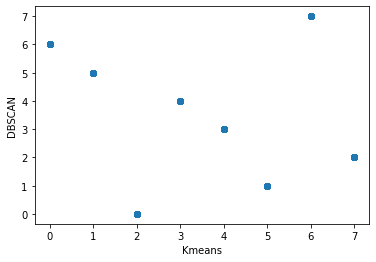

In [122]:
# let's se the correlation between the two clusters 
plt.scatter(labels_train_kmeans,labels_train_DB)
plt.xlabel('Kmeans')
plt.ylabel('DBSCAN')
plt.show()

as we can see from th graph there isn't much correlation between the two algorithms clusters, although both algortihms generated the same size of clusters. Now let's try to add both algoirthms clusters to the data and see how will that affect the accuracy of the logistic regression model

In [123]:
# adding both clusters to the data sets
X_train['kmeans'] = labels_train_kmeans
X_test['kmeans'] = labels_test_kmeans
X_train['DBSCAN'] = labels_train_DB
X_test['DBSCAN'] = labels_test_DB

display(X_train.head())
display(X_test.head())

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,DBSCAN,kmeans
4901,0.646,0.0,0.554054,0.0,0.709683,0.333333,0.0,1.0,0.104931,0,2
4375,1.000,0.0,0.310811,0.8,0.242651,0.000000,1.0,0.0,0.158774,1,5
6698,0.750,1.0,0.175676,0.6,0.000000,0.000000,0.0,0.0,0.306365,2,7
9805,0.588,0.0,0.202703,0.7,0.695786,0.000000,0.0,1.0,0.219396,0,2
1101,0.706,0.0,0.148649,0.9,0.000000,0.333333,1.0,0.0,0.253098,1,5


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,DBSCAN,kmeans
6252,0.492,0.0,0.189189,0.3,0.447500,0.333333,0.0,0.0,0.208904,0,3
4684,0.546,0.0,0.337838,0.1,0.000000,0.333333,1.0,1.0,0.731908,1,0
1731,0.502,1.0,0.351351,0.4,0.000000,0.333333,1.0,0.0,0.292777,2,1
4742,0.312,0.0,0.554054,0.8,0.551350,0.333333,1.0,1.0,0.853422,1,0
4521,0.420,1.0,0.121622,0.7,0.578391,0.000000,1.0,1.0,0.573346,3,4


In [124]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
both_report = evaluate_metrics(y_test,y_pred)
both_report

{'accuracy': 0.8096,
 'precision': array([0.8267009 , 0.56441718]),
 'Weighted precision': 0.7745588949179774,
 'recall': array([0.96455317, 0.18511066]),
 'Weighted recall': 0.8096,
 'f1score': array([0.89032258, 0.27878788]),
 'Weighted f1score': 0.7687494819159336}

In [125]:
both_results = list()
for key in keys:
       both_results.append(both_report.get(key))
both_results 

[0.8096, 0.7745588949179774, 0.8096, 0.7687494819159336]

In [126]:
final_results= {
    'Metric': ['Accuracy',' Weighted Recall','Weighted Precision','Weighted F1score'],
    'Row' :row_results,
    'Kmeans':kmeans_results,
    'DBSCAN':DBSCAN_results,
    'both algorithms':both_results}
final_results_table = pd.DataFrame(final_results).set_index('Metric')
display(final_results_table)

,Row,Kmeans,DBSCAN,both algorithms
Metric,,,,
Accuracy,0.809600,0.809600,0.808800,0.809600
Weighted Recall,0.774494,0.774628,0.772996,0.774559
Weighted Precision,0.809600,0.809600,0.808800,0.809600
Weighted F1score,0.768354,0.769142,0.767778,0.768749


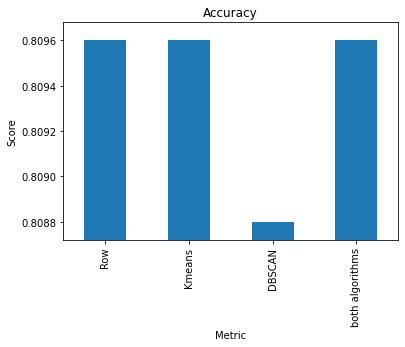

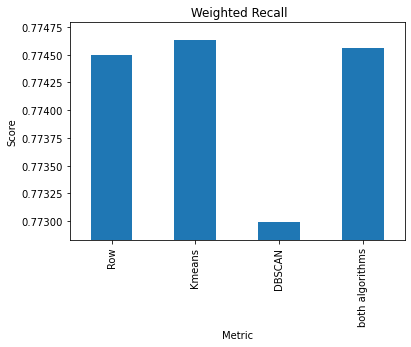

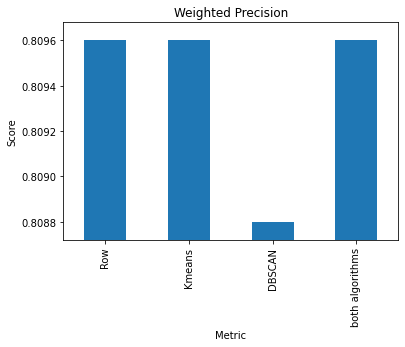

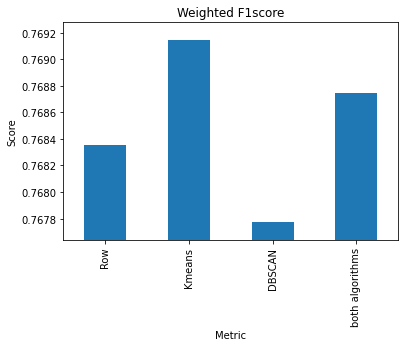

In [163]:
results = final_results

# Convert the dictionary to a DataFrame
df = pd.DataFrame(results)

# Set the Metric column as the index
df.set_index('Metric', inplace=True)
# Transposing the dataframe so that each column is a different metric
df=df.T

# Calculate the y-axis limit for each column
y_limits = []
for col in df.columns:
    col_range = max(df[col]) - min(df[col])
    y_limits.append((min(df[col]) - col_range * 0.1, max(df[col]) + col_range * 0.1))

# Plot a bar chart for each algorithm
for i, col in enumerate(df.columns):
    plt.figure()
    df[col].plot(kind='bar')
    plt.title(col)
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(y_limits[i])
    plt.show()

now we're gonna try to filter each data by its cluster label and train a logistic regression model for each cluster and see if the accuracy increase or not.

In [128]:
# creating 2 datasets for each clustering algorithm
X_train_kmeans = X_train.drop(['DBSCAN'], axis = 1)
X_test_kmeans = X_test.drop(['DBSCAN'], axis = 1)
X_train_DBSCAN = X_train.drop(['kmeans'], axis = 1)
X_test_DBSCAN = X_test.drop(['kmeans'], axis = 1)

In [129]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [130]:
kmeans_accuracy_list = []
kmeans_unique_value_list = []

for i in np.unique(kmeans.labels_):
    X_train = X_train_kmeans[X_train_kmeans['kmeans'] == i]
    X_test = X_test_kmeans[X_test_kmeans['kmeans'] == i]
    
    # Train a logistic regression model on the training data
    model = LogisticRegression()
    model.fit(X_train, y_train.loc[X_train.index])
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Compute the accuracy score
    accuracy = accuracy_score(y_test.loc[X_test.index], y_pred)
    
    # Append the accuracy and unique value to the corresponding lists
    kmeans_accuracy_list.append(accuracy)
    kmeans_unique_value_list.append(i)
    

Let's now see the performance of each logistic regression model on each cluster

In [133]:
import statistics

statistics.mean(kmeans_accuracy_list)


0.8257631049309992

In [138]:
# making a dictionary out of the two lists
kmeans_dict = dict(zip(kmeans_unique_value_list, kmeans_accuracy_list))
kmeans_dict

{0: 0.8932806324110671,
 1: 0.7788944723618091,
 2: 0.8985507246376812,
 3: 0.7745664739884393,
 4: 0.8125,
 5: 0.819327731092437,
 6: 0.8265895953757225,
 7: 0.8023952095808383}

In [140]:
# turing the keys of the dictionary to a string format and then adding the mean of the values to the dictionary 
kmeans_dict = {'0': 0.8932806324110671,
 '1': 0.7788944723618091,
 '2': 0.8985507246376812,
 '3': 0.7745664739884393,
 '4': 0.8125,
 '5': 0.819327731092437,
 '6': 0.8265895953757225,
 '7': 0.8023952095808383,
 'mean': 0.8257631049309992}

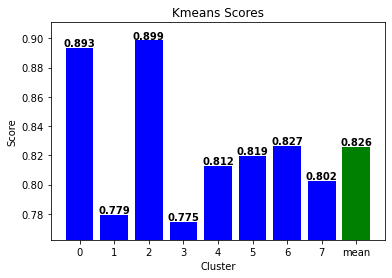

In [160]:


# create x and y values
x_values = list(kmeans_dict.keys())
y_values = list(kmeans_dict.values())

# set the color of the bars
colors = ['b'] * len(x_values)
for i in range(len(x_values)):
    if x_values[i] == 'mean':
        colors[i] = 'g'

# create a bar chart
fig, ax = plt.subplots()
ax.bar(x_values, y_values, color=colors)

# set the y-axis limits to match the minimum and maximum values in the data
ax.set_ylim([min(y_values)-0.1*(max(y_values)-min(y_values)), max(y_values)+0.1*(max(y_values)-min(y_values))])

# add the value of each y-axis on top of its corresponding bar
for i, v in enumerate(y_values):
    ax.text(i, v+0.01*(max(y_values)-min(y_values)), str(round(v, 3)), ha='center', fontweight='bold')

# add a title and axis labels
ax.set_title('Kmeans Scores')
ax.set_xlabel('Cluster')
ax.set_ylabel('Score')

# display the chart
plt.show()

we can see that the average accuracy of all models is higher than the accuracy obtained by merely training a logistic regression model on the oriiginal data, now let's do the same for DBSCAN clusters

In [84]:
np.unique(cluster.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [137]:
DBSCAN_accuracy_list = []
DBSCAN_unique_value_list = []

for i in np.unique(np.unique(cluster.labels_)):
    X_train = X_train_DBSCAN[X_train_DBSCAN['DBSCAN'] == i]
    X_test = X_test_DBSCAN[X_test_DBSCAN['DBSCAN'] == i]
    
    # Train a logistic regression model on the training data
    model = LogisticRegression()
    model.fit(X_train, y_train.loc[X_train.index])
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Compute the accuracy score
    accuracy = accuracy_score(y_test.loc[X_test.index], y_pred)
    
    # Append the accuracy and unique value to the corresponding lists
    DBSCAN_accuracy_list.append(accuracy)
    DBSCAN_unique_value_list.append(i)
    

In [144]:
# getting the accuracy mean
statistics.mean(DBSCAN_accuracy_list)


0.8045503516672704

In [143]:
DBSCAN_dict = dict(zip(DBSCAN_unique_value_list,DBSCAN_accuracy_list))
DBSCAN_dict

{0: 0.7514450867052023,
 1: 0.7924901185770751,
 2: 0.7738693467336684,
 3: 0.8125,
 4: 0.7485029940119761,
 5: 0.8382352941176471,
 6: 0.8208092485549133,
 7: 0.8985507246376812}

In [147]:
# turing the keys of the dictionary to a string format and then adding the mean of the values to the dictionary 

DBSCAN_dict = {'0': 0.7514450867052023,
 '1': 0.7924901185770751,
 '2': 0.7738693467336684,
 '3': 0.8125,
 '4': 0.7485029940119761,
 '5': 0.8382352941176471,
 '6': 0.8208092485549133,
 '7': 0.8985507246376812,
'mean': 0.8045503516672704}

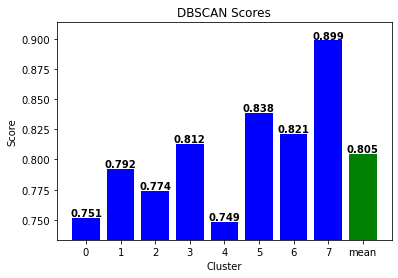

In [159]:
x_values = list(DBSCAN_dict.keys())
y_values = list(DBSCAN_dict.values())

# set the color of the bars
colors = ['b'] * len(x_values)
for i in range(len(x_values)):
    if x_values[i] == 'mean':
        colors[i] = 'g'

# create a bar chart
fig, ax = plt.subplots()
ax.bar(x_values, y_values, color=colors)

# set the y-axis limits to match the minimum and maximum values in the data
ax.set_ylim([min(y_values)-0.1*(max(y_values)-min(y_values)), max(y_values)+0.1*(max(y_values)-min(y_values))])

# add the value of each y-axis on top of its corresponding bar
for i, v in enumerate(y_values):
    ax.text(i, v+0.01*(max(y_values)-min(y_values)), str(round(v, 3)), ha='center', fontweight='bold')

# add a title and axis labels
ax.set_title('DBSCAN Scores')
ax.set_xlabel('Cluster')
ax.set_ylabel('Score')

# display the chart
plt.show()

## Key Findings
### Adding clustering results as a feature
* adding Kmeans clusters as a feature does not change the accuracy and it remains as 80.96%
* adding DBSCAN clusters as a feature reduce the accuracy to 80.88%
* addiing both clustering algorithms as features does not change the accuracy and it remain as 80.96%

### Training logisitc regression on each cluster
* The Kmeans average performance of all models is 82.6% which is higher than the row model.
* The DBSCAN average performance of all model is 80.5% which is lower than the row model.

## Conclusion 
In this project, we explored the use of clustering algorithms, namely Kmeans and DBSCAN, to improve the performance of a logistic regression model on a bank customer churn dataset. We first added clustering results as a feature to the dataset, which allowed the logistic regression to take advantage of the underlying structure in the data.

Our results showed that adding Kmeans clusters as a feature did not change the accuracy of the logistic regression model, which remained at 80.96%. On the other hand, adding DBSCAN clusters as a feature reduced the accuracy slightly to 80.88%. Interestingly, adding both clustering algorithms as features did not change the accuracy of the model, which also remained at 80.96%.

Next, we trained a separate logistic regression model on each cluster generated by the Kmeans and DBSCAN algorithms. The Kmeans average performance of all models was 82.6%, which was higher than the original model. This suggests that the Kmeans algorithm was able to identify meaningful clusters in the data that were not captured by the original model.

In contrast, the DBSCAN average performance of all models was 80.5%, which was lower than the original model. This suggests that the DBSCAN algorithm may have over-segmented the data, resulting in less meaningful clusters.

Overall, our findings highlight the importance of choosing the appropriate clustering algorithm for a given dataset. While Kmeans was able to identify useful clusters that improved the performance of the logistic regression model, DBSCAN did not perform as well. In addition, our results demonstrate the potential benefits of incorporating clustering results as features in machine learning models, which can help to uncover underlying patterns and improve predictive accuracy.